## TextRNN

TextRNN是一种基于递归神经网络（RNN）结构的文本分类模型，用于处理自然语言处理（NLP）任务。它可以接收变长的文本序列作为输入，并输出对文本的分类结果。

TextRNN的原理是利用RNN的循环结构来建模文本序列中的上下文信息。具体来说，TextRNN将文本序列中的每个词或字符依次输入RNN中，RNN会根据当前输入的词或字符以及前一个词或字符的隐状态来更新当前的隐状态，并输出一个隐藏状态表示当前位置的文本信息。通过将整个文本序列依次输入RNN，并将最终的隐藏状态输入一个全连接层进行分类，可以得到文本的分类结果。

TextRNN解决了传统的词袋模型（Bag of Words）和N-gram模型在处理文本时无法捕捉文本序列信息的问题。它可以更好地捕捉文本序列中的长期依赖关系，从而提高了文本分类的性能。

TextRNN最早由Lei, Z., Zhang, Y., & Lei, T.于2015年提出。与传统的RNN相比，TextRNN可以更好地捕捉文本序列中的长期依赖关系，从而提高了文本分类的性能。

LSTM（长短期记忆网络）和GRU（门控循环单元）是RNN的变种，它们可以用来替代传统的RNN单元。与传统的RNN相比，LSTM和GRU引入了门控机制，可以更有效地处理长序列，并且在一定程度上缓解了梯度消失和梯度爆炸问题。因此，TextRNN中的RNN单元可以选择使用LSTM或GRU来提高模型的性能和效率。

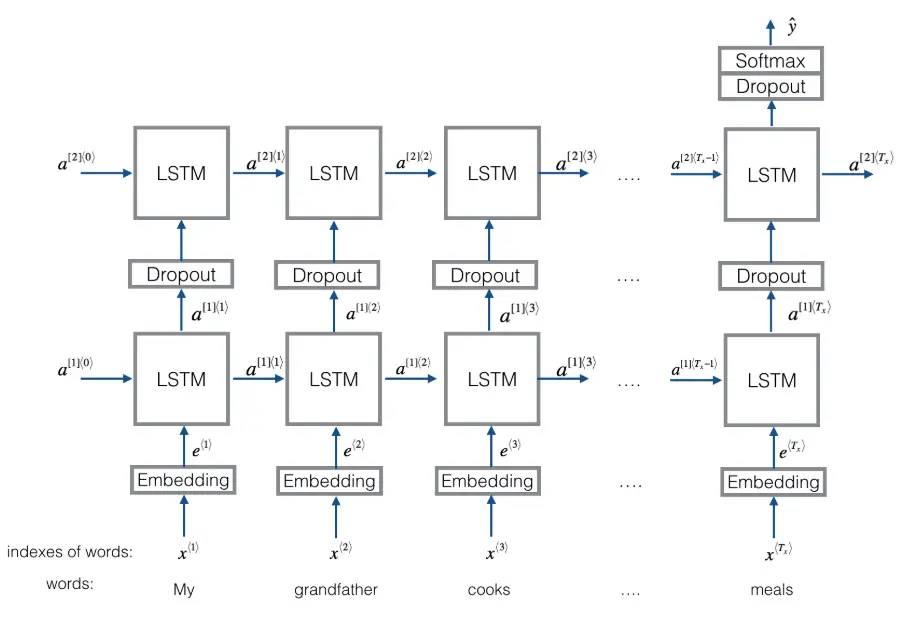

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report
import math

f:\download\sd\sd-webui-aki-v4.5\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#读取数据
df = pd.read_csv('分词后data.csv')
df = df.dropna()
print(df.head())

                                                  文本  标签
0                       商业秘密 秘密性 维系 商业价值 垄断 地位 前提条件    0
1  南口 阿玛施 新春 第一批 限量 春装 店 春暖花开 淑女 裙冰 蓝色 公主 衫 气质 粉小...   1
2                                 带给 常州 一场 壮观 视觉 盛宴    0
3                                     原因 不明 泌尿系统 结石    0
4                                    年 盐城 拉回来 麻麻 嫁妆    0


In [3]:
data = df['文本'].tolist()
label = df['标签'].tolist()
print(len(data), len(label)) #查看语料信息
print(Counter(label)) #查看不同标签文本数量

1241 1241
Counter({0: 1119, 1: 122})


In [4]:
texts = [each.split() for each in data]
print(data[0:5])

['商业秘密 秘密性 维系 商业价值 垄断 地位 前提条件 ', '南口 阿玛施 新春 第一批 限量 春装 店 春暖花开 淑女 裙冰 蓝色 公主 衫 气质 粉小 西装 冰丝 女王 长半裙 皇 ', '带给 常州 一场 壮观 视觉 盛宴 ', '原因 不明 泌尿系统 结石 ', '年 盐城 拉回来 麻麻 嫁妆 ']


In [5]:
#构建词表，将文本中的字符单词替换为数字索引
word_vocb=[]
word_vocb.append('')
for text in texts:
    for word in text:
        word_vocb.append(word)
word_vocb=set(word_vocb)
vocb_size=len(word_vocb)

In [6]:
print(vocb_size)

5919


In [7]:
#词表与索引的映射
word_to_idx={word:i for i,word in enumerate(word_vocb)}
idx_to_word={word_to_idx[word]:word for word in word_to_idx}

In [8]:
import pickle

In [9]:
#保存词表与索引，每次生成不同，为读取以保存CNN模型使用
with open('word_to_idx.pkl',mode='wb') as f3:
    pickle.dump(word_to_idx,f3)
    pickle.dump(idx_to_word,f3)

In [10]:
#读取词表与索引
with open('word_to_idx.pkl',mode='rb') as f4:
    word_to_idx=pickle.load(f4)
    idx_to_word=pickle.load(f4)

In [11]:
print(word_to_idx['商业价值'])
print(idx_to_word[222])

1306
属


In [12]:
#演示文本最大长度设置为30
max_len = 30
#生成训练数据，删除超过max_len的部分，不够的补0
texts_with_id=np.zeros([len(texts),max_len])
for i in range(0,len(texts)):
    if len(texts[i])<max_len:
        for j in range(0,len(texts[i])):
            texts_with_id[i][j]=word_to_idx[texts[i][j]]
        for j in range(len(texts[i]),max_len):
            texts_with_id[i][j] = word_to_idx['']
    else:
        for j in range(0,max_len):
            texts_with_id[i][j]=word_to_idx[texts[i][j]]

In [13]:
print(texts_with_id.shape)
print(texts_with_id[0])

(1241, 30)
[  63. 3329. 1275. 1306.  582. 3491. 5627.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.]


In [14]:
#TextRNN模型
class TextRNN(nn.Module):
    def __init__(self,args):
        super(TextRNN, self).__init__()
        vocb_size = args['vocb_size']
        dim = args['dim'] #词向量维度
        n_class = args['n_class']
        max_len = args['max_len']
        embedding_matrix=args['embedding_matrix']
        hidden_size = 128 #隐藏层单元
        num_layers = 2 #RNN层数
        dropout = 0.5 #防过拟合随机丢失
        
        #需要将事先训练好的词向量载入
        self.embedding = nn.Embedding(vocb_size, dim,_weight=embedding_matrix)
        
        self.lstm = nn.LSTM(dim, hidden_size, num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size * 2, n_class)
        
    def forward(self, x):
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[128, 32, 300]
        #print(out.size())
        out, _ = self.lstm(out)
        #print(out.size())
        out = self.fc(out[:, -1, :])  # 句子最后时刻的 hidden state
        return out

## ChatGPT 生成的代码解释

这段代码定义了一个**TextRNN模型**，用于处理文本分类任务。让我逐步解释一下：

1. **模型结构**：
    - 这是一个继承自`nn.Module`的PyTorch模型类，名为`TextRNN`。
    - 模型包含以下几个主要组件：
        - 词嵌入层（`self.embedding`）：用于将输入的词索引转换为词向量。
        - 双向LSTM层（`self.lstm`）：用于处理序列数据，捕捉上下文信息。
        - 全连接层（`self.fc`）：用于将LSTM输出映射到分类标签。

2. **初始化方法**（`__init__`）：
    - 接收一个参数`args`，其中包含以下信息：
        - `vocb_size`：词汇表大小。
        - `dim`：词向量维度。
        - `n_class`：分类类别数。
        - `max_len`：最大序列长度。
        - `embedding_matrix`：预训练的词向量矩阵。
    - 初始化模型的各个组件：
        - `self.embedding`：使用预训练的词向量矩阵作为权重。
        - `self.lstm`：双向LSTM，包含指定数量的隐藏层单元和层数。
        - `self.fc`：全连接层，将LSTM输出映射到分类标签。

3. **前向传播方法**（`forward`）：
    - 输入`x`是一个表示文本序列的张量，其形状为`[batch_size, seq_len]`。
    - 首先，通过词嵌入层将词索引转换为词向量。
    - 然后，将词向量输入到双向LSTM中，获取LSTM的输出。
    - 最后，将LSTM输出的最后一个时间步的隐藏状态（双向拼接）传递给全连接层，得到分类结果。

总之，这段代码定义了一个TextRNN模型，用于文本分类任务，其中包含词嵌入层、双向LSTM和全连接层。

In [15]:
args = {}

word_dim = 300 #词向量的维度
n_class = 2 #类别

#textCNN调用的参数
args['vocb_size']=vocb_size
args['max_len']=max_len
args['n_class']=n_class
args['dim']=word_dim

In [17]:
#word2vec词向量
cn_model = KeyedVectors.load_word2vec_format('..\\4 词向量文档表示模型\\sgns.weibo.word.bz2', binary=False)

In [18]:
#embedding层的参数大小为vocb_size*dim，即词汇表大小乘词向量的维度 又称为lookup表
embedding_matrix = np.zeros((vocb_size, word_dim))

for word, i in word_to_idx.items():
    if word in cn_model:
        embedding_vector = cn_model[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
args['embedding_matrix']=torch.Tensor(embedding_matrix)

In [19]:
import pickle

In [20]:
#保存所用到的词向量矩阵
with open('embedding_matrix.pickle', mode='wb') as f1:
    pickle.dump(embedding_matrix, f1)

In [21]:
#读取所用到的词向量矩阵
with open('embedding_matrix.pickle', mode='rb') as f1:
    embedding_matrix = pickle.load(f1)
args['embedding_matrix']=torch.Tensor(embedding_matrix)

In [22]:
print(embedding_matrix.shape)
print(embedding_matrix[4])

(5919, 300)
[ 2.66777009e-01 -3.21888000e-01  1.06982999e-01  4.06881988e-01
 -2.35284001e-01  2.07417995e-01 -7.13749975e-02  9.79600009e-03
 -1.02040004e-02  3.87019999e-02  4.89437014e-01 -4.52923000e-01
  1.77261993e-01 -1.68048993e-01 -1.98004007e-01 -1.23511001e-01
  8.94000009e-03 -7.98579976e-02  1.91118002e-01 -3.07499990e-03
 -2.65389998e-02  8.91100019e-02 -8.55510011e-02 -1.76001996e-01
  2.71526009e-01  4.52105999e-01 -3.73569012e-01 -3.21689010e-01
  1.10633001e-01 -9.94110033e-02 -4.64556009e-01 -3.64602000e-01
  3.66749987e-02 -1.85245007e-01  3.16985011e-01  1.97410002e-01
 -1.18947998e-01 -2.59909987e-01 -2.11236000e-01 -2.34621003e-01
  1.71119999e-02 -1.52693003e-01  1.91820003e-02 -4.57255006e-01
 -1.61532998e-01  3.99289988e-02  1.89420003e-02  1.80934995e-01
  1.45190001e-01 -8.16679969e-02 -5.86280003e-02 -2.52126008e-01
  2.56309986e-01  2.21190006e-02  3.26329991e-02  2.46580005e-01
  4.58799988e-01  1.10041000e-01 -3.09166014e-01 -1.75816000e-01
  1.05021000e

In [23]:
#构建TextRNN模型
rnn=TextRNN(args)
print(rnn) #输出模型结构

TextRNN(
  (embedding): Embedding(5919, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [24]:
total_params = 0
for name, parameters in rnn.named_parameters():
    if not parameters.requires_grad: continue
    print(name, ':', parameters.size())
    total_params += parameters.numel()
print("模型需要训练参数为：", total_params)

embedding.weight : torch.Size([5919, 300])
lstm.weight_ih_l0 : torch.Size([512, 300])
lstm.weight_hh_l0 : torch.Size([512, 128])
lstm.bias_ih_l0 : torch.Size([512])
lstm.bias_hh_l0 : torch.Size([512])
lstm.weight_ih_l0_reverse : torch.Size([512, 300])
lstm.weight_hh_l0_reverse : torch.Size([512, 128])
lstm.bias_ih_l0_reverse : torch.Size([512])
lstm.bias_hh_l0_reverse : torch.Size([512])
lstm.weight_ih_l1 : torch.Size([512, 256])
lstm.weight_hh_l1 : torch.Size([512, 128])
lstm.bias_ih_l1 : torch.Size([512])
lstm.bias_hh_l1 : torch.Size([512])
lstm.weight_ih_l1_reverse : torch.Size([512, 256])
lstm.weight_hh_l1_reverse : torch.Size([512, 128])
lstm.bias_ih_l1_reverse : torch.Size([512])
lstm.bias_hh_l1_reverse : torch.Size([512])
fc.weight : torch.Size([2, 256])
fc.bias : torch.Size([2])
模型需要训练参数为： 2611798


In [25]:
#参数设置

EPOCH = 3; #轮次，根据训练情况设置

LR = 0.001 #学习率，根据训练情况设置
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR) #优化器
#损失函数
loss_function = nn.CrossEntropyLoss()
#训练批次大小，和内存显存相关
epoch_size=100;
texts_len=len(texts_with_id)
print(texts_len)
#划分训练数据和测试数据
x_train, x_test, y_train, y_test = train_test_split(texts_with_id, label, test_size=0.2, random_state=42)
 
test_x=torch.LongTensor(x_test)
test_y=torch.LongTensor(y_test)
train_x=x_train
train_y=y_train
 
test_epoch_size=200;

1241


In [26]:
print(x_train.shape)
print(label[0:10])
print(y_train[0:10])

(992, 30)
[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [27]:
for epoch in range(EPOCH):
    train_acc_all = 0
    for i in range(0, math.ceil(len(train_x)/epoch_size)):
 
        b_x = Variable(torch.LongTensor(train_x[i*epoch_size:i*epoch_size+epoch_size]))
 
        b_y = Variable(torch.LongTensor((train_y[i*epoch_size:i*epoch_size+epoch_size])))
        output = rnn(b_x)
        loss = loss_function(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('batch: ' + str(i) + " 损失:" + str(loss.data))
        pred_y = torch.max(output, 1)[1].data.squeeze()
        acc = (b_y == pred_y)
        acc = acc.numpy().sum()
        train_acc_all = train_acc_all + acc
 
    acc_all = 0;
    for j in range(0, math.ceil(len(test_x) / test_epoch_size)):
        b_x = Variable(torch.LongTensor(test_x[j * test_epoch_size:j * test_epoch_size + test_epoch_size]))
        b_y = Variable(torch.LongTensor((test_y[j * test_epoch_size:j * test_epoch_size + test_epoch_size])))
        test_output = rnn(b_x)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        # print(pred_y)
        # print(test_y)
        acc = (pred_y == b_y)
        acc = acc.numpy().sum()
        #print("准确率 " + str(acc / b_y.size(0)))
        acc_all = acc_all + acc
 
    train_accuracy = train_acc_all / len(train_y)
    test_accuracy = acc_all / (test_y.size(0))
    print("epoch " + str(epoch) + " " + "训练集准确率：" + str(train_accuracy) + " 测试集准确率：" + str(test_accuracy))

batch: 0 损失:tensor(0.6785)
batch: 1 损失:tensor(0.6580)
batch: 2 损失:tensor(0.6217)
batch: 3 损失:tensor(0.5786)
batch: 4 损失:tensor(0.5435)
batch: 5 损失:tensor(0.5038)
batch: 6 损失:tensor(0.4381)
batch: 7 损失:tensor(0.3869)
batch: 8 损失:tensor(0.3281)
batch: 9 损失:tensor(0.2267)
epoch 0 训练集准确率：0.9042338709677419 测试集准确率：0.891566265060241
batch: 0 损失:tensor(0.2076)
batch: 1 损失:tensor(0.4887)
batch: 2 损失:tensor(0.3532)
batch: 3 损失:tensor(0.2178)
batch: 4 损失:tensor(0.2119)
batch: 5 损失:tensor(0.2374)
batch: 6 损失:tensor(0.1675)
batch: 7 损失:tensor(0.2610)
batch: 8 损失:tensor(0.1895)
batch: 9 损失:tensor(0.1359)
epoch 1 训练集准确率：0.9193548387096774 测试集准确率：0.927710843373494
batch: 0 损失:tensor(0.1457)
batch: 1 损失:tensor(0.1898)
batch: 2 损失:tensor(0.2029)
batch: 3 损失:tensor(0.1894)
batch: 4 损失:tensor(0.1533)
batch: 5 损失:tensor(0.1478)
batch: 6 损失:tensor(0.1009)
batch: 7 损失:tensor(0.1858)
batch: 8 损失:tensor(0.1451)
batch: 9 损失:tensor(0.1101)
epoch 2 训练集准确率：0.9556451612903226 测试集准确率：0.9397590361445783


In [28]:
test_output = rnn(test_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
#输出结果报告
print(classification_report(test_y, pred_y, digits=4, target_names = ['正常短信', '垃圾短信']))

              precision    recall  f1-score   support

        正常短信     0.9442    0.9910    0.9670       222
        垃圾短信     0.8750    0.5185    0.6512        27

    accuracy                         0.9398       249
   macro avg     0.9096    0.7548    0.8091       249
weighted avg     0.9367    0.9398    0.9328       249

